# Student Project 1

In [1]:
"""
Student scores dataset + visualizations + linear regression + evaluation

Requirements:
pip install numpy pandas matplotlib seaborn scikit-learn
"""

# -------------------------
# 0) Imports and settings
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, precision_score, mean_squared_error


In [2]:

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -------------------------
# 1) Create synthetic dataset
# -------------------------
# Number of students
n_students = 100

# Create student IDs
student_ids = [f"S{idx:03d}" for idx in range(1, n_students + 1)]

# Generate random midterm and final scores (0-100)
# We'll use normal distributions clipped to [0,100] to look realistic
mid_term = np.clip(np.random.normal(loc=65, scale=15, size=n_students), 0, 100)
final = np.clip(np.random.normal(loc=68, scale=14, size=n_students), 0, 100)

# Generate random presence (attendance percentage 0-100)
presence = np.clip(np.random.normal(loc=85, scale=10, size=n_students), 0, 100)

# Optionally include another 'scores' column (e.g., homework average)
homework = np.clip(np.random.normal(loc=75, scale=12, size=n_students), 0, 100)

# Compute average score (explicitly requested: average of mid_term and final)
average = (mid_term + final) / 2.0

# Put everything into a pandas DataFrame
df = pd.DataFrame({
    "student_id": student_ids,
    "mid_term": mid_term,
    "final": final,
    "presence": presence,
    "homework": homework,
    "average": average
})

# Show top rows (optional, for debugging / quick check)
print("First 6 rows of generated dataset:")
print(df.head(6).to_string(index=False))


First 6 rows of generated dataset:
student_id  mid_term     final  presence  homework   average
      S001 72.450712 48.184810 88.577874 65.052060 60.317761
      S002 62.926035 62.110965 90.607845 68.277828 62.518500
      S003 74.715328 63.201997 95.830512 83.967523 68.958662
      S004 87.845448 56.768118 95.538021 82.324443 72.306783
      S005 61.487699 65.742000 71.223306 74.749181 63.614850
      S006 61.487946 73.656712 75.621750 76.407929 67.572329


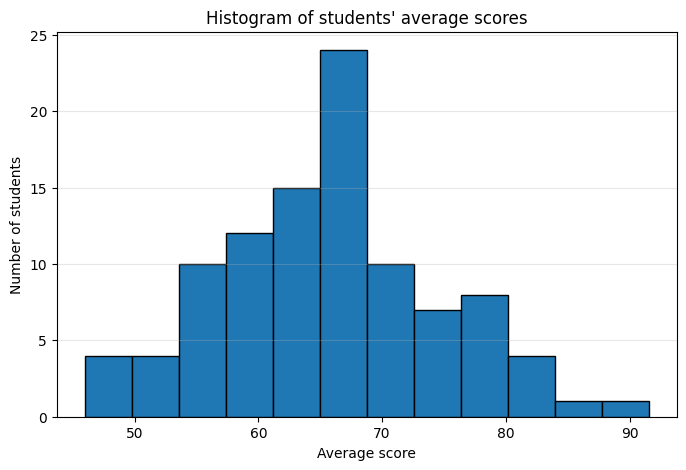

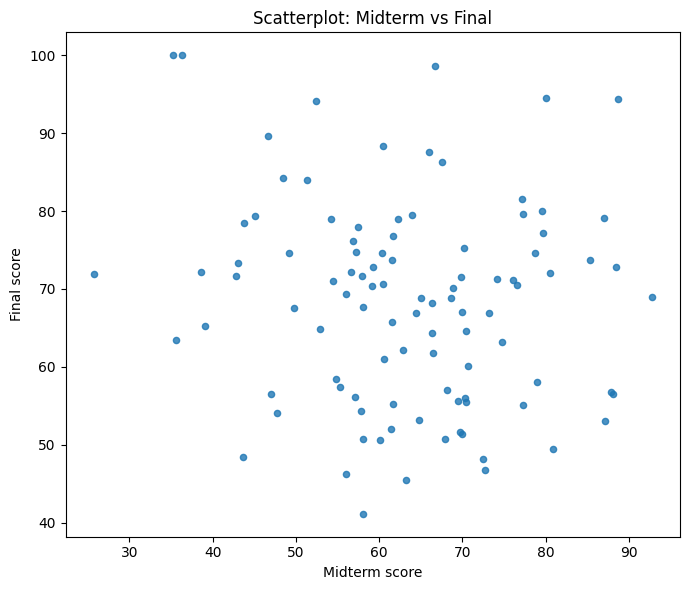

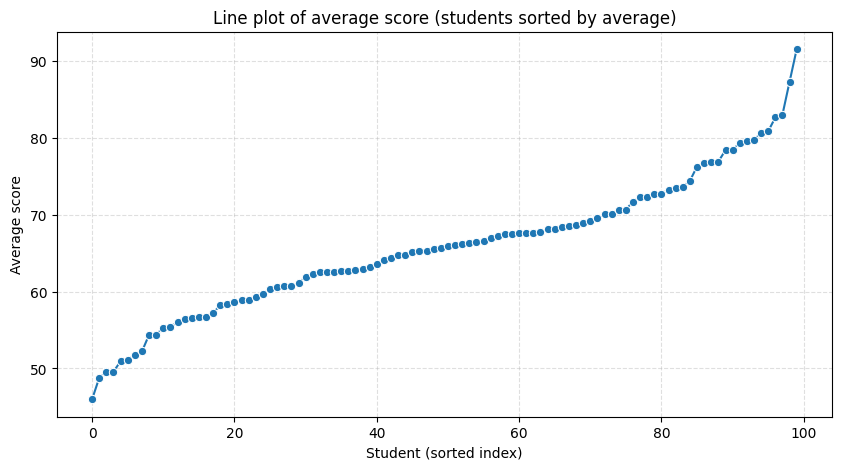

In [9]:
# -------------------------
# 2) Visualizations
#    - Histogram (matplotlib)
#    - Scatterplot (pandas)
#    - Line plot (seaborn)
# -------------------------

# 2A) Histogram of the 'average' column using matplotlib
plt.figure(figsize=(8, 5))
plt.hist(df['average'], bins=12, edgecolor='black')
plt.title("Histogram of students' average scores")
plt.xlabel("Average score")
plt.ylabel("Number of students")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2B) Scatterplot using pandas plotting: mid_term vs final
# This visualizes relation between midterm and final scores
ax = df.plot.scatter(x='mid_term', y='final', figsize=(7, 6), alpha=0.8)
ax.set_title("Scatterplot: Midterm vs Final")
ax.set_xlabel("Midterm score")
ax.set_ylabel("Final score")
plt.tight_layout()
plt.show()

# 2C) Line plot of average scores by student (seaborn)
# We'll sort by average so the line plot is meaningful (increasing trend)
df_sorted = df.sort_values(by='average').reset_index(drop=True)

plt.figure(figsize=(10, 5))
# ✅ FIX: add `data=df_sorted`
sns.lineplot(data=df_sorted, x=df_sorted.index, y='average', marker='o')

plt.title("Line plot of average score (students sorted by average)")
plt.xlabel("Student (sorted index)")
plt.ylabel("Average score")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [4]:

# -------------------------
# 3) Prepare features and target for regression
#    We'll predict 'average' using mid_term, final, presence.
#    NOTE: average is computed from mid_term & final, so predicting it from them
#    will be almost perfect; for demonstration we still do this, and we also
#    show how to predict 'final' from mid_term and presence as a more realistic task.
# -------------------------

# Features and targets for two tasks
X = df[['mid_term', 'final', 'presence']]  # features for average prediction
y_avg = df['average']                       # target: average (derived)
X_final = df[['mid_term', 'presence']]     # features for predicting final
y_final = df['final']                       # target: final


In [5]:

# -------------------------
# 4) Train/test split + Linear Regression (predicting average)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_avg, test_size=0.2, random_state=RANDOM_SEED)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions on test set
y_pred = lr.predict(X_test)

# Regression evaluation (R^2 and MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("\n--- Predicting 'average' (train/test split) ---")
print(f"R^2 on test set: {r2:.4f}")
print(f"MSE on test set: {mse:.4f}")

# For 'precision' (classification metric) we convert to pass/fail
# Define pass threshold (e.g., >= 50 is pass)
threshold = 50
y_test_bin = (y_test >= threshold).astype(int)
y_pred_bin = (y_pred >= threshold).astype(int)
prec = precision_score(y_test_bin, y_pred_bin, zero_division=0)
print(f"Precision (treating >= {threshold} as pass): {prec:.4f}")



--- Predicting 'average' (train/test split) ---
R^2 on test set: 1.0000
MSE on test set: 0.0000
Precision (treating >= 50 as pass): 1.0000


In [6]:

# -------------------------
# 5) 5-fold Cross-validation (Regression R^2)
#    We'll run 5-fold CV for the LinearRegression model predicting 'average'.
# -------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
cv_r2_scores = cross_val_score(lr, X, y_avg, cv=kf, scoring='r2')
print("\n--- 5-fold cross-validation (R^2) for predicting 'average' ---")
print(f"R^2 scores for each fold: {cv_r2_scores}")
print(f"Mean R^2 (5-fold): {cv_r2_scores.mean():.4f}, Std: {cv_r2_scores.std():.4f}")

# For a cross-validated precision estimate:
# Use cross_val_predict to get out-of-fold predictions, then compute precision on binarized results
y_pred_cv = cross_val_predict(lr, X, y_avg, cv=kf)
y_true_bin = (y_avg >= threshold).astype(int)
y_pred_cv_bin = (y_pred_cv >= threshold).astype(int)
cv_precision = precision_score(y_true_bin, y_pred_cv_bin, zero_division=0)
print(f"Cross-validated precision (threshold={threshold}): {cv_precision:.4f}")



--- 5-fold cross-validation (R^2) for predicting 'average' ---
R^2 scores for each fold: [1. 1. 1. 1. 1.]
Mean R^2 (5-fold): 1.0000, Std: 0.0000
Cross-validated precision (threshold=50): 1.0000


In [7]:

# -------------------------
# 6) Extra: A more realistic regression task
#    Predicting 'final' from 'mid_term' and 'presence' (final not computed directly).
#    We'll demonstrate train/test split and CV for this task as well.
# -------------------------
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=RANDOM_SEED)

lr_final = LinearRegression()
lr_final.fit(Xf_train, yf_train)
yf_pred = lr_final.predict(Xf_test)
r2_final = r2_score(yf_test, yf_pred)
mse_final = mean_squared_error(yf_test, yf_pred)
print("\n--- Predicting 'final' from mid_term & presence (train/test split) ---")
print(f"R^2 on test set: {r2_final:.4f}")
print(f"MSE on test set: {mse_final:.4f}")

# Cross-validated R^2 for this task
cv_r2_final = cross_val_score(lr_final, X_final, y_final, cv=kf, scoring='r2')
print("\n5-fold CV R^2 for predicting 'final':")
print(f"Fold R^2 scores: {cv_r2_final}")
print(f"Mean R^2: {cv_r2_final.mean():.4f}, Std: {cv_r2_final.std():.4f}")

# Cross-validated precision for 'final' (binarize with same threshold)
y_final_pred_cv = cross_val_predict(lr_final, X_final, y_final, cv=kf)
y_final_bin = (y_final >= threshold).astype(int)
y_final_pred_cv_bin = (y_final_pred_cv >= threshold).astype(int)
cv_precision_final = precision_score(y_final_bin, y_final_pred_cv_bin, zero_division=0)
print(f"Cross-validated precision for 'final' (threshold={threshold}): {cv_precision_final:.4f}")



--- Predicting 'final' from mid_term & presence (train/test split) ---
R^2 on test set: 0.0043
MSE on test set: 172.8111

5-fold CV R^2 for predicting 'final':
Fold R^2 scores: [ 0.00431207 -0.1012553  -0.05589291 -0.16813773 -0.96622283]
Mean R^2: -0.2574, Std: 0.3589
Cross-validated precision for 'final' (threshold=50): 0.9300


In [8]:

# -------------------------
# 7) Wrap-up and notes
# -------------------------
print("\nNotes:")
print("- 'average' was computed exactly as (mid_term + final) / 2, so predicting it using both mid_term and final")
print("  will yield extremely high R^2 (the model sees the components).")
print("- Precision is shown by converting continuous predictions into pass/fail at a threshold (>= 50).")
print("- If you want to predict a label directly (pass/fail) consider using a classifier (LogisticRegression) and")
print("  then report precision/recall/F1 directly for classification.")



Notes:
- 'average' was computed exactly as (mid_term + final) / 2, so predicting it using both mid_term and final
  will yield extremely high R^2 (the model sees the components).
- Precision is shown by converting continuous predictions into pass/fail at a threshold (>= 50).
- If you want to predict a label directly (pass/fail) consider using a classifier (LogisticRegression) and
  then report precision/recall/F1 directly for classification.
